In [28]:
import pandas as pd
import numpy as np

import os
import cv2
from PIL import Image
import urllib.request

import tqdm
import warnings
warnings.filterwarnings('ignore')
import random
import re

from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras.utils

In [29]:
df =  pd.read_csv('train.csv')

In [30]:
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [31]:
test = pd.read_csv('test.csv')

In [32]:
df.groupby('anatom_site_general_challenge').count()


,image_name,patient_id,sex,age_approx,diagnosis,benign_malignant,target
anatom_site_general_challenge,,,,,,,
head/neck,1855,1855,1847,1845,1855,1855,1855
lower extremity,8417,8417,8399,8399,8417,8417,8417
oral/genital,124,124,124,124,124,124,124
palms/soles,375,375,375,375,375,375,375
torso,16845,16845,16826,16825,16845,16845,16845
upper extremity,4983,4983,4963,4963,4983,4983,4983


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [34]:
df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

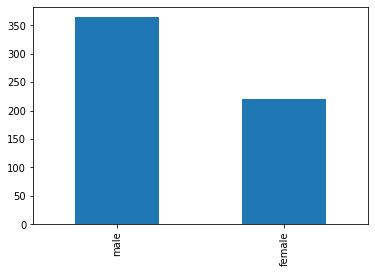

In [35]:
df[df['diagnosis'] == 'melanoma']['sex'].value_counts().plot.bar()

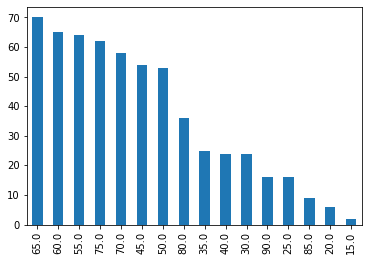

In [36]:
df[df['diagnosis'] == 'melanoma']['age_approx'].value_counts().plot.bar()

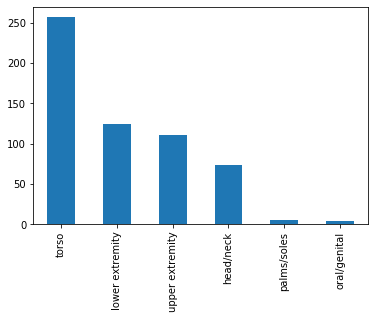

In [37]:
df[df.target==1]['anatom_site_general_challenge'].value_counts().plot.bar()

In [38]:
df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [39]:
df_train = df[['sex', 'age_approx', 'anatom_site_general_challenge', 'target']]
df_train

,sex,age_approx,anatom_site_general_challenge,target
0,male,45.0,head/neck,0
1,female,45.0,upper extremity,0
2,female,50.0,lower extremity,0
3,female,45.0,head/neck,0
4,female,55.0,upper extremity,0
...,...,...,...,...
33121,male,50.0,torso,0
33122,male,65.0,torso,0
33123,male,20.0,lower extremity,0
33124,male,50.0,lower extremity,0


In [40]:
df_train = pd.get_dummies(df_train, prefix = ['sex', 'anatom_site_general_challenge'], drop_first=True)

In [41]:
df_train = df_train.dropna()

In [42]:
df_train.columns

Index(['age_approx', 'target', 'sex_male',
       'anatom_site_general_challenge_lower extremity',
       'anatom_site_general_challenge_oral/genital',
       'anatom_site_general_challenge_palms/soles',
       'anatom_site_general_challenge_torso',
       'anatom_site_general_challenge_upper extremity'],
      dtype='object')

In [43]:
df_train.columns
X = df_train[['age_approx', 'sex_male',
       'anatom_site_general_challenge_lower extremity',
       'anatom_site_general_challenge_oral/genital',
       'anatom_site_general_challenge_palms/soles',
       'anatom_site_general_challenge_torso',
       'anatom_site_general_challenge_upper extremity']]
y = df_train['target']

In [44]:
X

,age_approx,sex_male,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,45.0,1,0,0,0,0,0
1,45.0,0,0,0,0,0,1
2,50.0,0,1,0,0,0,0
3,45.0,0,0,0,0,0,0
4,55.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
33121,50.0,1,0,0,0,1,0
33122,65.0,1,0,0,0,1,0
33123,20.0,1,1,0,0,0,0
33124,50.0,1,1,0,0,0,0


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1200, max_depth=2)
model = rf.fit(X_train, y_train)

In [20]:
from sklearn.metrics import classification_report
def report(model):
    y_pred = model.predict(X_train)
    return print(classification_report(y_train, y_pred))
    
report(model)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22727
           1       0.00      0.00      0.00       413

    accuracy                           0.98     23140
   macro avg       0.49      0.50      0.50     23140
weighted avg       0.96      0.98      0.97     23140



In [21]:
from imblearn.over_sampling import SMOTE

In [22]:
smote = SMOTE(sampling_strategy={1: 5000})
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [195]:
y_resampled.value_counts()

0    22727
1     5000
Name: target, dtype: int64

In [196]:
model_1 = rf.fit(X_resampled, y_resampled)

In [197]:
report(model_1)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     22727
           1       0.10      0.20      0.13       413

    accuracy                           0.95     23140
   macro avg       0.54      0.58      0.55     23140
weighted avg       0.97      0.95      0.96     23140



In [141]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy={0: 10000})
X_resampled_nm, y_resampled_nm = nm.fit_resample(X_train, y_train)
print(y_resampled_nm.value_counts())
model_2 = rf.fit(X_resampled_nm, y_resampled_nm)
report(model_2)

0    10000
1      413
Name: target, dtype: int64
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     22727
           1       0.01      0.10      0.02       413

    accuracy                           0.83     23140
   macro avg       0.50      0.47      0.46     23140
weighted avg       0.96      0.83      0.89     23140



In [190]:
from imblearn.under_sampling import RandomUnderSampler
nm = NearMiss(sampling_strategy={0: 20000})
X_resampled_nm, y_resampled_nm = nm.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy={1: 15000})
X_resampled, y_resampled = smote.fit_resample(X_resampled_nm, y_resampled_nm)
print(y_resampled.value_counts())
model_3 = rf.fit(X_resampled, y_resampled)
report(model_3)

0    20000
1    15000
Name: target, dtype: int64
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     22727
           1       0.04      0.45      0.07       413

    accuracy                           0.80     23140
   macro avg       0.51      0.63      0.48     23140
weighted avg       0.97      0.80      0.87     23140



In [45]:
PATH = '/storage/Melanoma/melanoma/jpeg/train/'

In [46]:
def load_reshape_img(image):
    img = load_img(image, target_size=(224, 224))
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x

In [52]:
datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.8,
        fill_mode='nearest'       
       )


df_target = df[df.target == 1]
X = np.array([load_reshape_img(PATH + image + '.jpg') for image in df_target.image_name])
X = X.reshape(X.shape[0], 224, 224, 3)    
i = 0
for batch in tqdm.tqdm(datagen.flow(X, batch_size=70,
                          save_to_dir='/storage/Melanoma/melanoma/jpeg/aug/', 
                          save_prefix="melanoma_aug", 
                          save_format='jpeg')):        
    i += 1
    if i > 40:
        break

40it [01:03,  1.58s/it]                      


In [76]:
df_2 = df

In [77]:
df_2

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [78]:
aug_img = os.listdir('/storage/Melanoma/melanoma/jpeg/aug')
df_aug = pd.DataFrame()
df_aug['image_name'] = aug_img
df_aug['target'] = 1
df_aug['patient_id'] = 0
df_2 = pd.concat([df_aug, df_2])

In [50]:
augmented_images = os.listdir('/storage/Melanoma/melanoma/jpeg/aug')

In [71]:
df_2

,image_name,target,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
0,melanoma_aug_146_7363.jpeg,1,0,NaN,NaN,NaN,NaN,NaN
1,melanoma_aug_138_2045.jpeg,1,0,NaN,NaN,NaN,NaN,NaN
2,melanoma_aug_553_8631.jpeg,1,0,NaN,NaN,NaN,NaN,NaN
3,melanoma_aug_128_1303.jpeg,1,0,NaN,NaN,NaN,NaN,NaN
4,melanoma_aug_217_3078.jpeg,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,0,IP_6526534,male,50.0,torso,unknown,benign
33122,ISIC_9999320,0,IP_3650745,male,65.0,torso,unknown,benign
33123,ISIC_9999515,0,IP_2026598,male,20.0,lower extremity,unknown,benign
33124,ISIC_9999666,0,IP_7702038,male,50.0,lower extremity,unknown,benign


In [71]:
!cp /storage/Melanoma/melanoma/jpeg/aug/* /storage/Melanoma/melanoma/jpeg/train/   # copying augmented images to the main data folder

In [104]:
model_v3 = InceptionV3(weights='imagenet', include_top=False, classes=2, input_shape=(224, 224, 3))
new_layers = model_v3.output

new_layers = GlobalAveragePooling2D()(new_layers)

new_layers = Dense(128, activation='relu')(new_layers)
new_layers = Dropout(0.5)(new_layers)
new_layers = BatchNormalization()(new_layers)

new_layers = Dense(2, activation='softmax')(new_layers)
model_v3 = Model(inputs=model_v3.inputs, outputs=new_layers)

In [105]:
# Freezing the first 51 layers
for layer in model_v3.layers[:52]:
    layer.trainable = False

In [106]:
model_v3.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #Stochastic gradient descent optimizer.


In [107]:
df_2['target'][df_2['target'] == 1] = 'Melanoma'
df_2['target'][df_2['target'] == 0] = 'Normal'

In [108]:
df_2

,image_name,target,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant
0,melanoma_aug_146_7363.jpeg,Melanoma,0,NaN,NaN,NaN,NaN,NaN
1,melanoma_aug_138_2045.jpeg,Melanoma,0,NaN,NaN,NaN,NaN,NaN
2,melanoma_aug_553_8631.jpeg,Melanoma,0,NaN,NaN,NaN,NaN,NaN
3,melanoma_aug_128_1303.jpeg,Melanoma,0,NaN,NaN,NaN,NaN,NaN
4,melanoma_aug_217_3078.jpeg,Melanoma,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,Normal,IP_6526534,male,50.0,torso,unknown,benign
33122,ISIC_9999320,Normal,IP_3650745,male,65.0,torso,unknown,benign
33123,ISIC_9999515,Normal,IP_2026598,male,20.0,lower extremity,unknown,benign
33124,ISIC_9999666,Normal,IP_7702038,male,50.0,lower extremity,unknown,benign


In [114]:
df_2.target.value_counts()

Normal      32542
Melanoma     3270
Name: target, dtype: int64

In [115]:
train_datagen = ImageDataGenerator(validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(
    df_2,
    directory='/storage/Melanoma/melanoma/jpeg/train/',
    x_col="image_name",
    y_col="target",
    subset="training",
     classes = ['Melanoma', 'Normal'],
    target_size=(224, 224),
    class_mode="binary")

valid_generator =train_datagen.flow_from_dataframe(
    df_2,
    directory='/storage/Melanoma/melanoma/jpeg/train/',
    x_col="image_name",
    y_col="target",
   subset="validation",
    classes = ['Melanoma', 'Normal'],
    target_size=(224, 224),
    class_mode="binary")

model_v3.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 32,
    epochs = 10)



Found 2149 validated image filenames belonging to 2 classes.
Found 537 validated image filenames belonging to 2 classes.
Epoch 1/10
67/67 [==============================] - 38s 570ms/step - loss: 0.9168 - accuracy: 0.5314 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 2/10
67/67 [==============================] - 39s 577ms/step - loss: 0.7955 - accuracy: 0.5834 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 3/10
67/67 [==============================] - 38s 565ms/step - loss: 0.7096 - accuracy: 0.6297 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 4/10
67/67 [==============================] - 38s 566ms/step - loss: 0.6372 - accuracy: 0.6608 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 5/10
67/67 [==============================] - 38s 569ms/step - loss: 0.5788 - accuracy: 0.6982 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
Epoch 6/10
67/67 [==============================] - 39s 579ms/step - loss: 0.5138 - accuracy: 0.7430 - val_loss: 1.1921e-07 - val_accuracy: 1.00

KeyboardInterrupt: 

In [102]:
valid_generator.get_classes(df_2, 'Normal')

KeyError: 'Normal'

In [98]:
y_pred = model_v3.predict_generator(valid_generator,steps= 32)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(valid_generator.classes, y_pred_bool, target_names=['covid', 'normal']))

ValueError: Found input variables with inconsistent numbers of samples: [537, 1017]